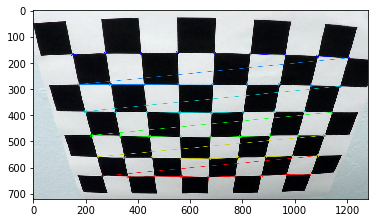

In [8]:
#Calibrating the camera
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


In [12]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
import glob

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#print(" objp = ",objp)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    else :
        print("Not used- ",fname)

cv2.destroyAllWindows()

Not used-  camera_cal\calibration1.jpg
Not used-  camera_cal\calibration4.jpg
Not used-  camera_cal\calibration5.jpg


(720, 1280)


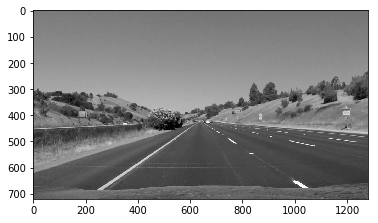

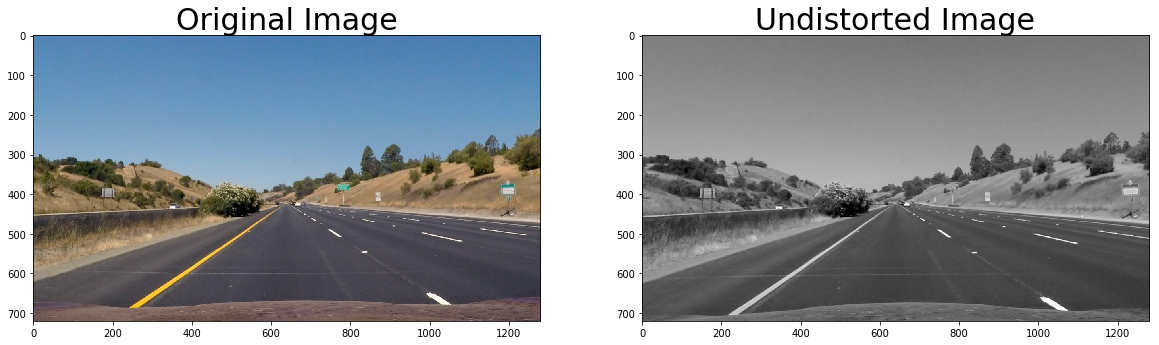

In [26]:
import pickle
img = mpimg.imread('test_images/straight_lines1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap = 'gray')
print(gray.shape)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

undistorted = cv2.undistort(gray, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',undistorted)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted, cmap = 'gray')
ax2.set_title('Undistorted Image', fontsize=30)

## Perspective Transform

Image shape (720, 1280, 3)
size_y 720
size_x 1280
src.shape (4, 2)
dst.shape (4, 2)


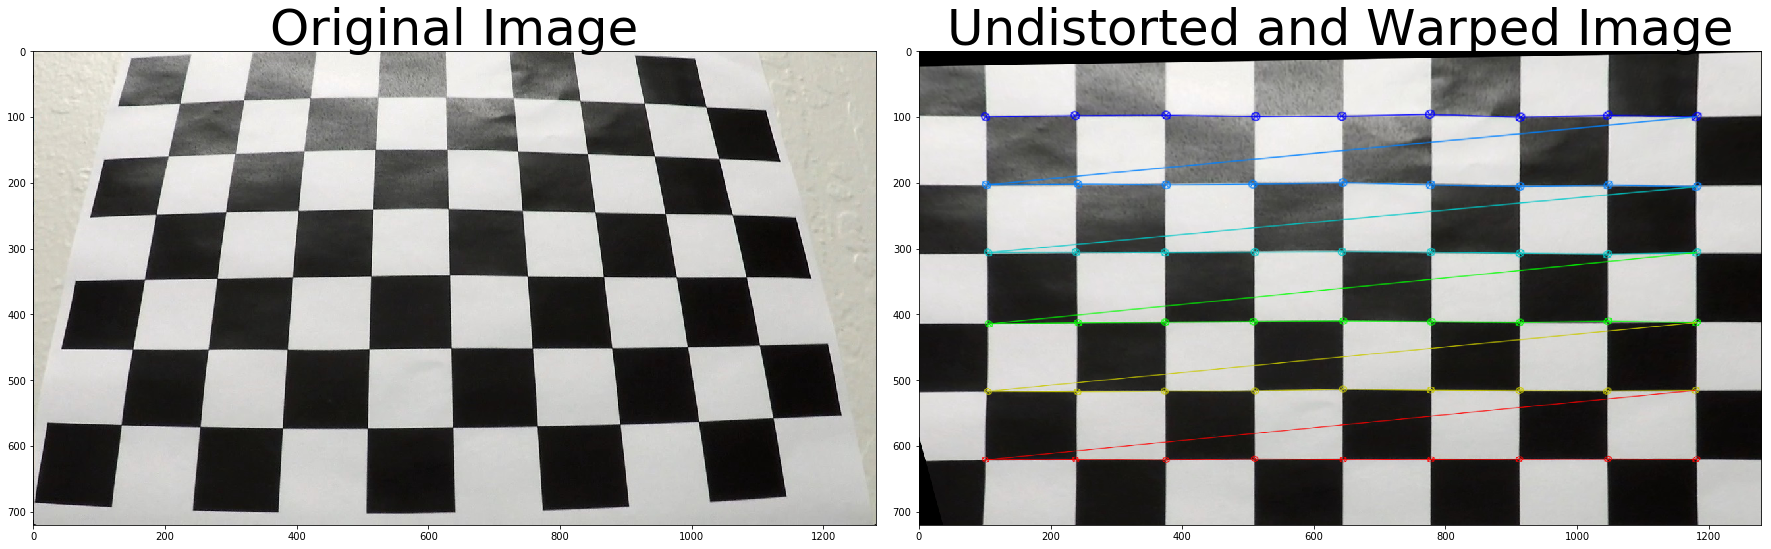

In [37]:
dist_pickle = pickle.load( open( "output_images/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = mpimg.imread('camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
print("Image shape", img.shape)
size_y = img.shape[0]
size_x = img.shape[1]
print("size_y",size_y)
print("size_x",size_x)

MARGIN = 100
# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    img = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    #print(corners)
    if ret== True:
        cv2.drawChessboardCorners(img, (nx,ny), corners,ret)
        # source points
        src = corners[0,0,:]
        src = np.append(src,corners[nx-1,0,:])
        src = np.append(src,corners[nx*ny-nx,0,:])
        src = np.append(src,corners[nx*ny-1,0,:])
        src = src.reshape(-1,2)
        
        #print("src",src)
        
        # destination points
        
        dst = np.float32([[MARGIN,MARGIN],[size_x-MARGIN,MARGIN],[MARGIN,size_y-MARGIN],[size_x-MARGIN,size_y-MARGIN]])
        print("src.shape",src.shape)
        print("dst.shape",dst.shape)
        M = cv2.getPerspectiveTransform(src,dst)
        warped = cv2.warpPerspective(img, M, (size_x,size_y) , flags=cv2.INTER_LINEAR)
        
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective on Test Image


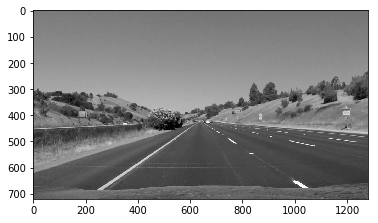

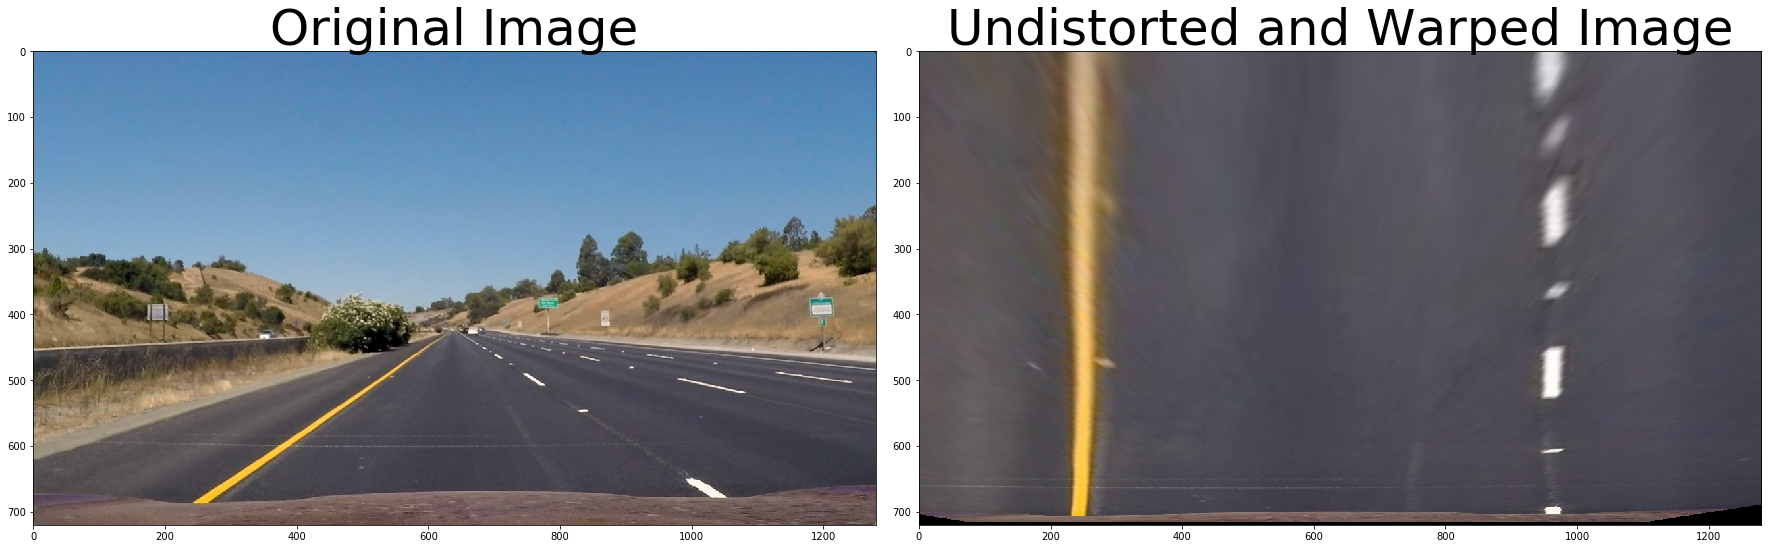

In [54]:
dist_pickle = pickle.load( open( "output_images/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = mpimg.imread('test_images/straight_lines1.jpg')
gray  = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap = 'gray')
#print(img.shape)
src = np.float32([[285,670],[1017,670],[596,450],[683,450]])
dst = np.float32([[250,700],[950,700],[250,0],[950,0]])

#src = np.float32([[670,285],[670,1017],[450,596],[450,683]])
#dst = np.float32([[700,250],[700,950],[0,250],[0,950]])


M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(src,dst)
warped = cv2.warpPerspective(img, M, (gray.shape[::-1]) , flags=cv2.INTER_LINEAR)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




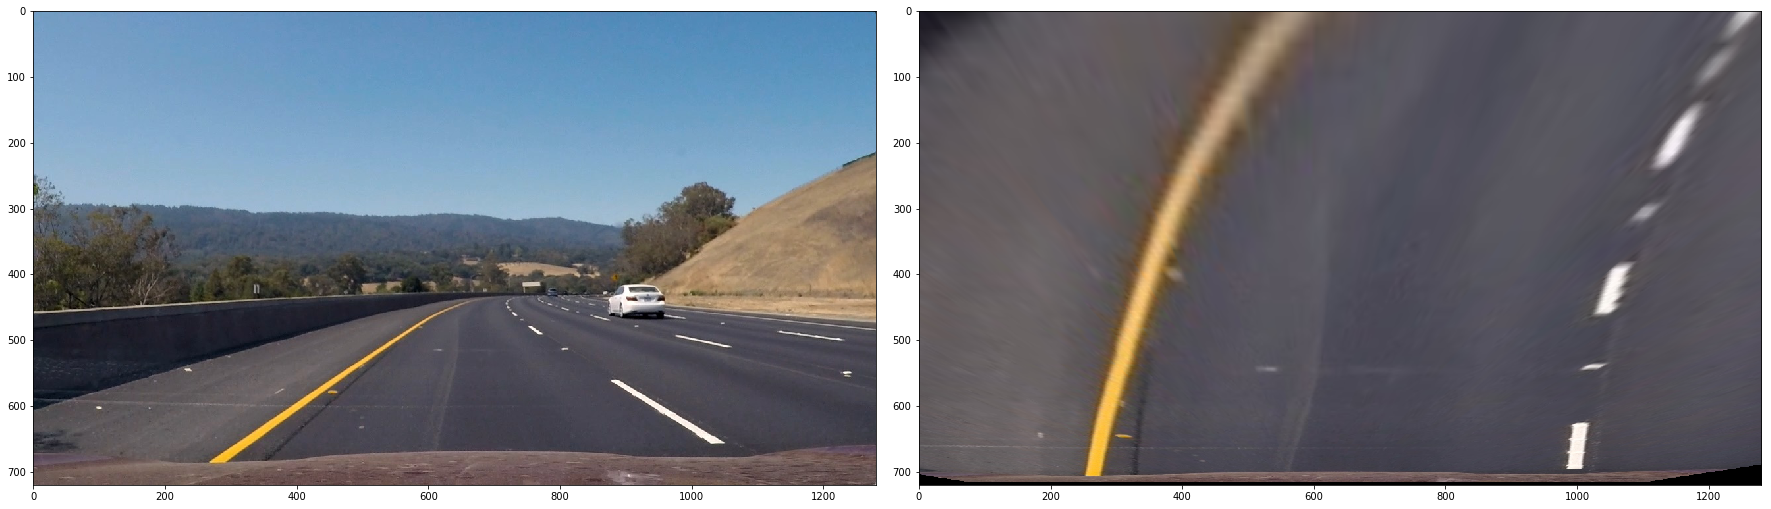

In [57]:
# definition
def plot_two_images(img1,img2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax2.imshow(img2)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def rgb_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def bgr_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = mpimg.imread('test_images/test3.jpg')
gray = rgb_gray(img)
warped = cv2.warpPerspective(img, M, (gray.shape[::-1]) , flags=cv2.INTER_LINEAR)

plot_two_images(img, warped)

    

In [ ]:
#Trying for other images

